## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'ES'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-41.69540,-20.31110,834.860,978430.53,978432.684100,-2.154100
1,-41.76060,-20.28400,580.510,978481.32,978499.082245,-17.762245
2,-39.94830,-18.83860,43.860,978557.90,978559.797486,-1.897486
3,-40.13470,-18.95430,66.550,978553.15,978561.606958,-8.456958
4,-40.16120,-19.02320,69.260,978555.25,978563.416211,-8.166211
...,...,...,...,...,...,...
334,-40.22627,-19.63165,60.934,978583.82,978574.609022,9.210978
335,-40.37948,-18.98960,97.142,978538.27,978542.750332,-4.480332
336,-40.86754,-19.88745,177.944,978541.92,978547.857478,-5.937478
337,-40.67634,-19.48096,119.745,978547.11,978551.958431,-4.848431


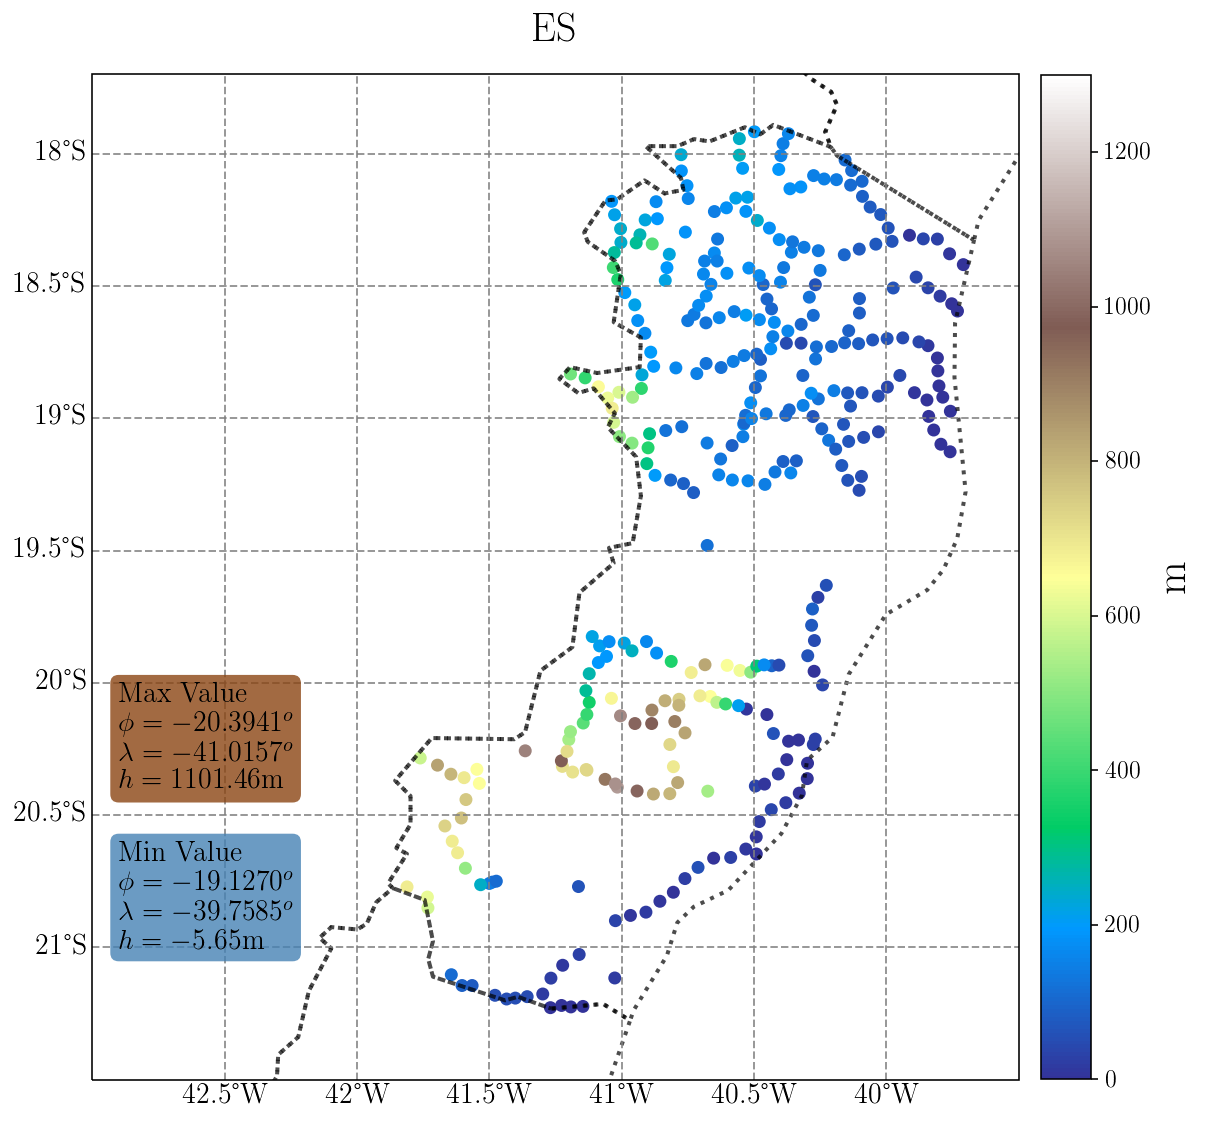

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
          sign=(-42.9,-42.9,-20.4,-21), cmap='terrain', lim_val=(True,True,0.,1300.), shrink=0.77)

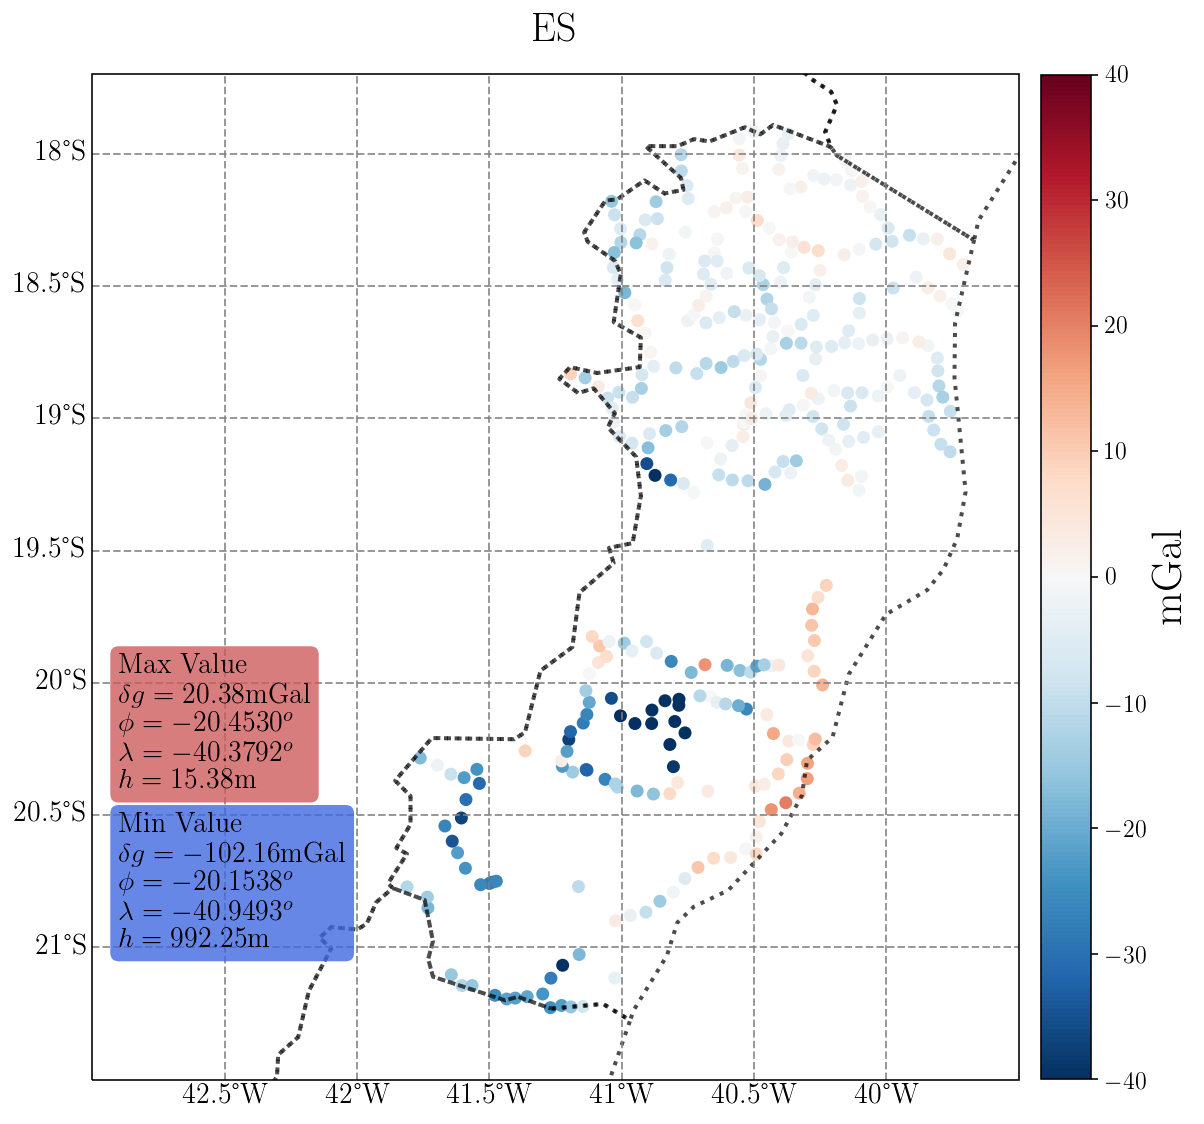

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
          sign=(-42.9,-42.9,-20.4,-21), lim_val=(True, 40.), shrink=0.77)

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 52 1101.46 -11.576435700058937
MIN 250 -5.65 -10.300297500099987


In [9]:
index_max = np.argmax(df.DIST.values)
print('MAX', index, df.ALT[index], df.DIST[index_max])

index_min = np.argmin(df.DIST.values)
print('MIN', index, df.ALT[index], df.DIST[index_min])
print(disturb.size)

MAX 250 -5.65 20.375927899964154
MIN 250 -5.65 -102.16319950006437
339


In [10]:
# disturb = np.delete(df.DIST.values, np.array(index_min))
# longitude = np.delete(df.LONG.values, np.array(index_min))
# latitude = np.delete(df.LAT.values, np.array(index_min))
# altitude = np.delete(df.ALT.values, np.array(index_min))
# print(disturb.size, longitude.size, latitude.size, altitude.size)

In [11]:
# index_max = np.argmax(disturb)
# print('MAX', index, altitude[index], disturb[index_max])

In [12]:
# point_map(longitude, latitude, altitude, disturb, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
#           sign=(-42.9,-42.9,-20.4,-21), lim_val=(True, 40.), shrink=0.77)

### Calculating rotation matrices and Cartesian coordinates

In [13]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))
# x, y, z = geodetic2cartesian(longitude, latitude, altitude)
# R = np.array(rotation_matrix(longitude, latitude))

## Estimating the first set of point-mass parameters

In [14]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [15]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [16]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]
# latcl = latitude[indl]
# loncl = longitude[indl]

In [17]:
Rcl = R[:, indl]

In [18]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(339, 339)


In [19]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [20]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

339


In [21]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [22]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

6.679101716144942e-13

In [23]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [24]:
rabs_max.append(rabs_max_l)

In [25]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

6.679101716144942e-13


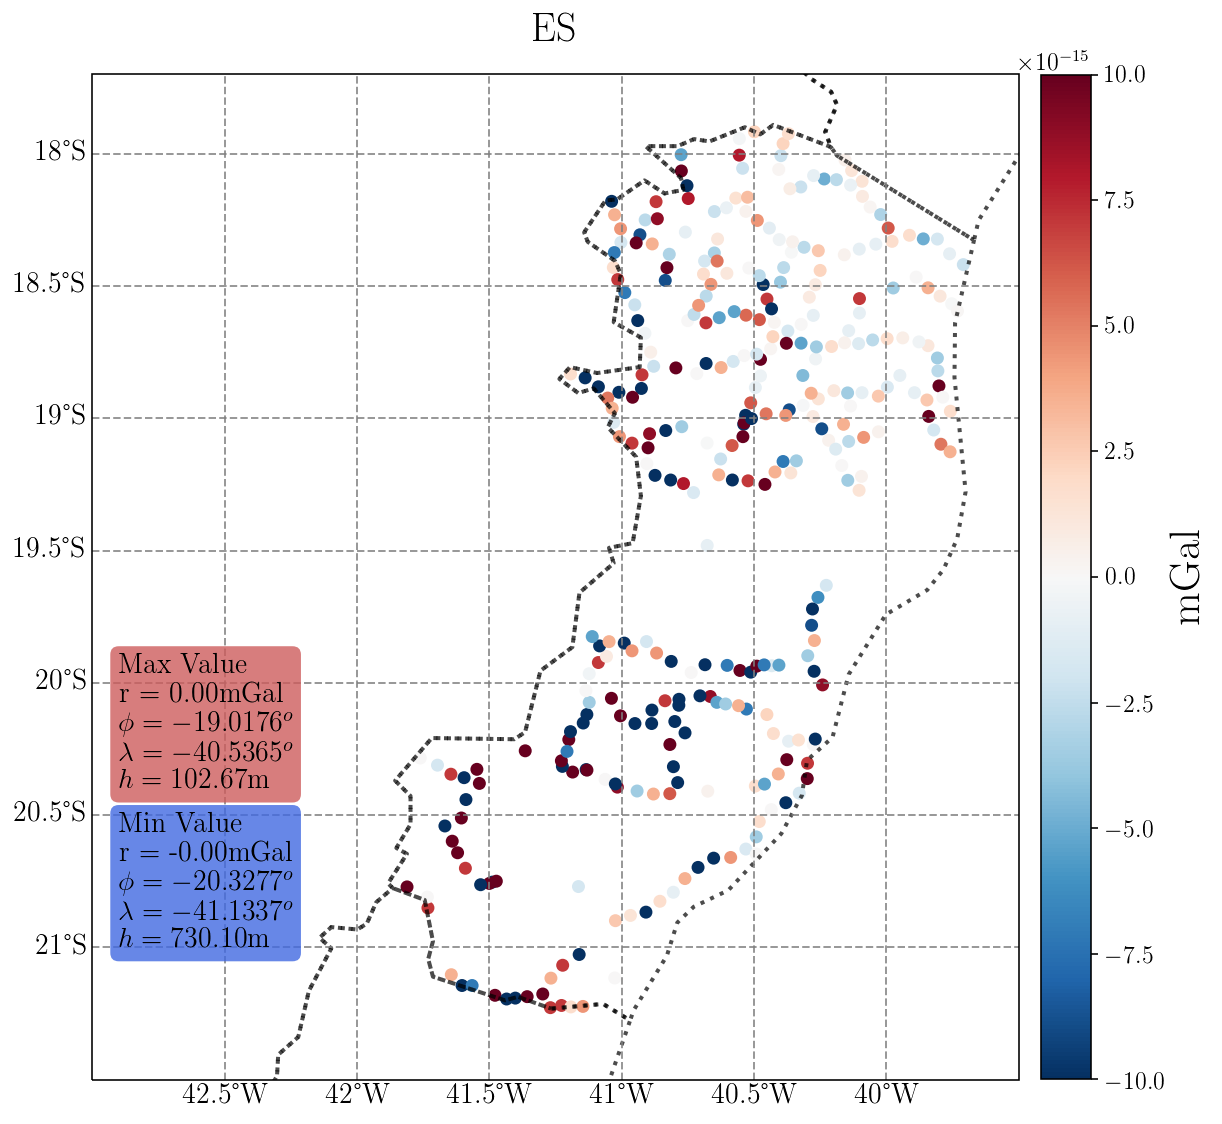

In [26]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
          sign=(-42.9,-42.9,-20.4,-21), residual=True, lim_val=(True, 1e-14), shrink=0.77)

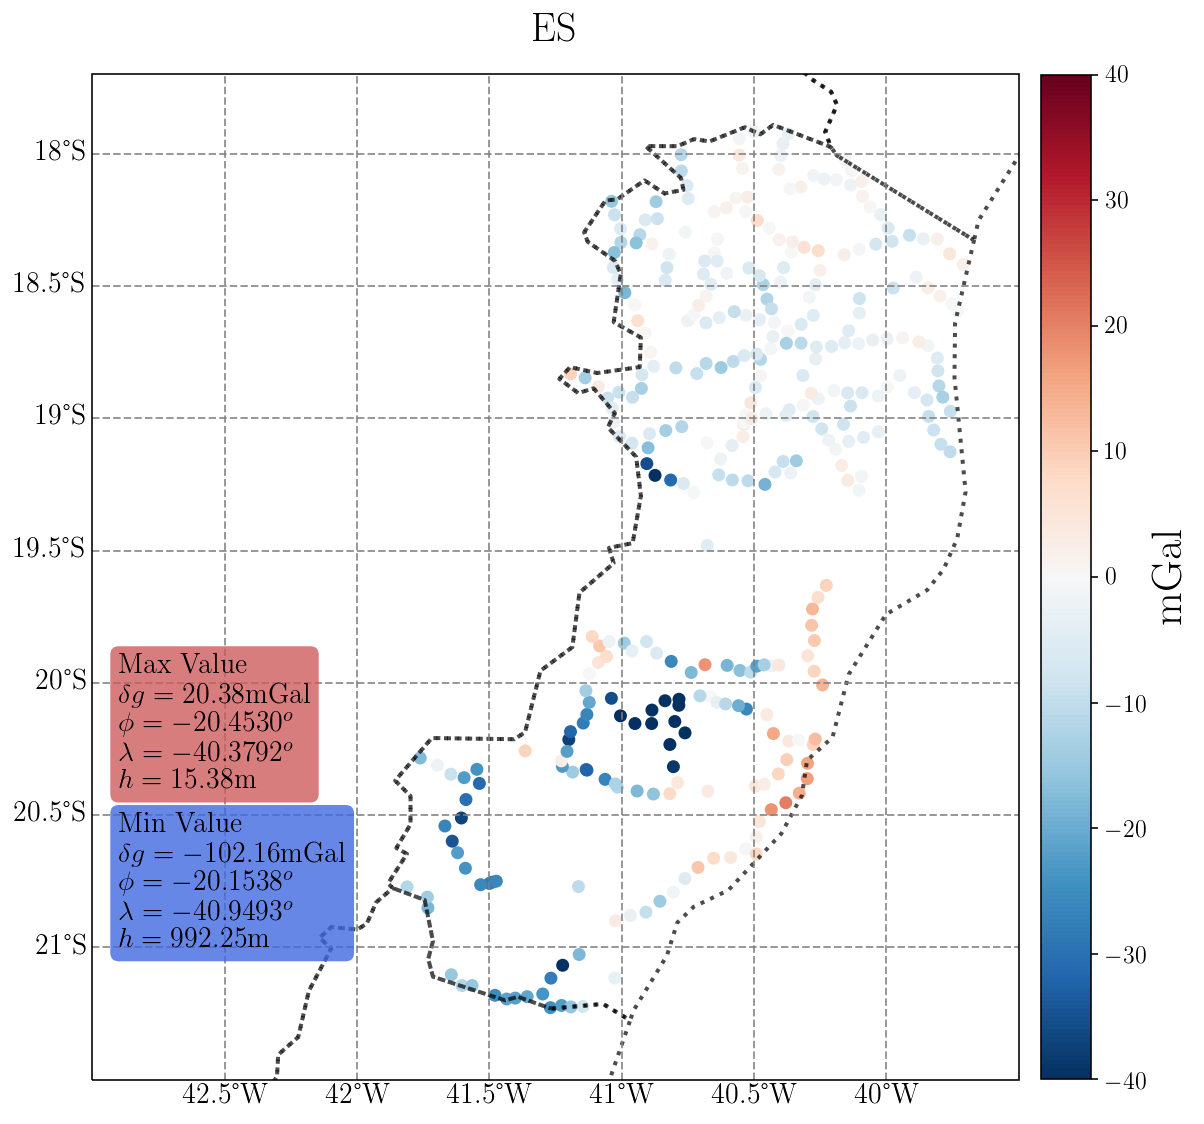

In [27]:
point_map(df.LONG, df.LAT, df.ALT, disturb, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
          sign=(-42.9,-42.9,-20.4,-21), lim_val=(True, 40.), shrink=0.77)

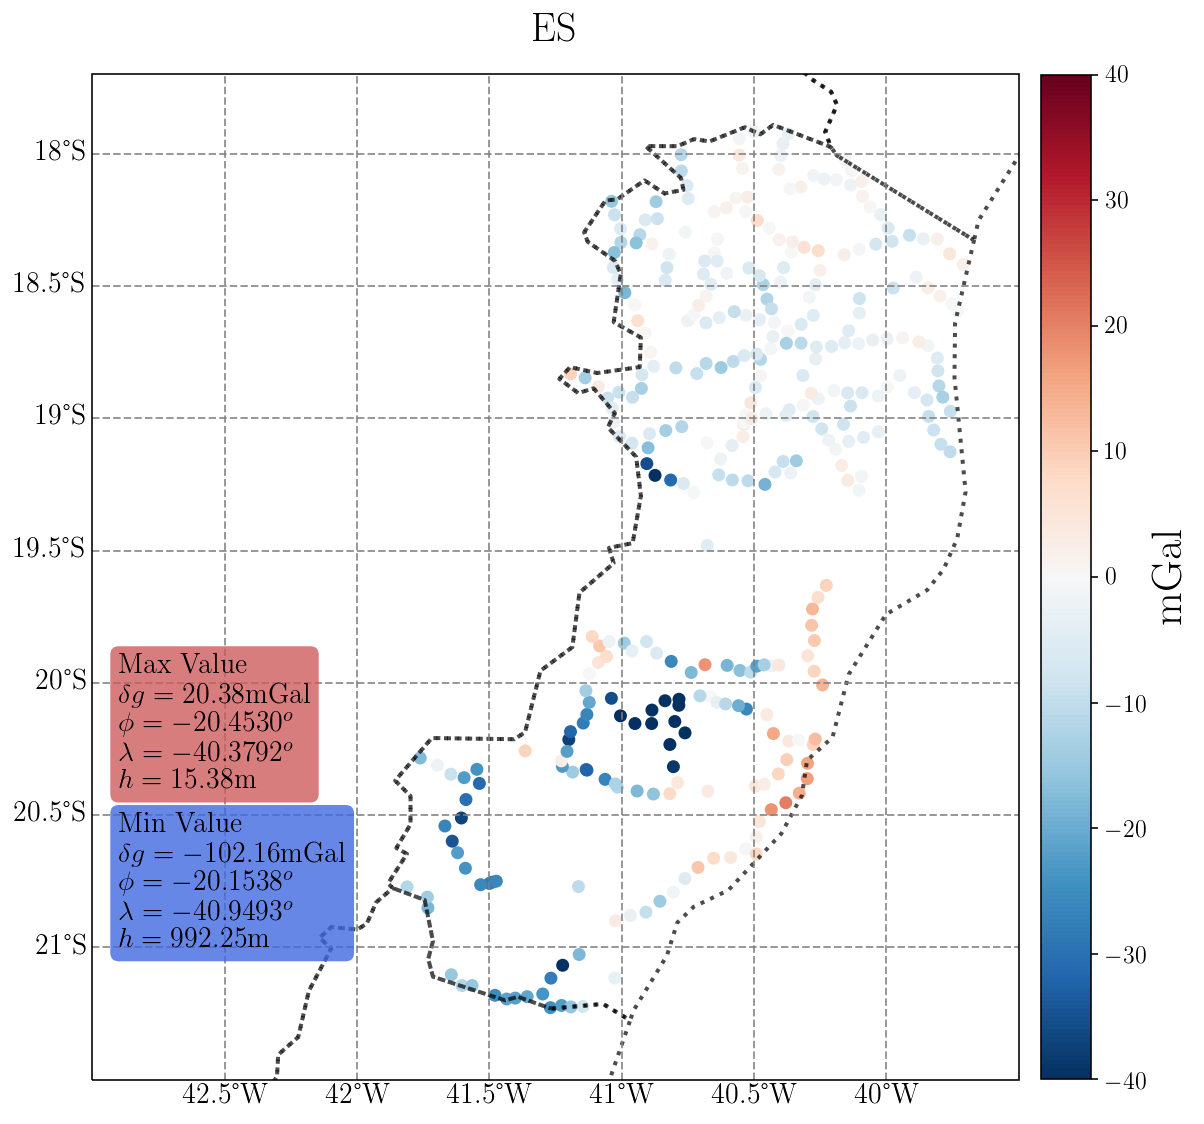

In [28]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(10.,12.), \
          region=[-43,-39.5,-21.5,-17.7], sign=(-42.9,-42.9,-20.4,-21), shrink=0.77, lim_val=(True, 40.))

In [29]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [30]:
# point_map(df.LONG, df.LAT, df.ALT
new_data = {'LONG':df.LONG, \
            'LAT':df.LAT, \
            'ALT':df.ALT, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-41.69540,-20.31110,834.860,978430.53,978432.684100,-2.154100,5.963398e+11,-1.776357e-15
1,-41.76060,-20.28400,580.510,978481.32,978499.082245,-17.762245,-7.917741e+12,0.000000e+00
2,-39.94830,-18.83860,43.860,978557.90,978559.797486,-1.897486,-4.744189e+11,-8.881784e-16
3,-40.13470,-18.95430,66.550,978553.15,978561.606958,-8.456958,-2.340170e+12,0.000000e+00
4,-40.16120,-19.02320,69.260,978555.25,978563.416211,-8.166211,-2.353381e+12,3.552714e-15
...,...,...,...,...,...,...,...,...
334,-40.22627,-19.63165,60.934,978583.82,978574.609022,9.210978,2.877319e+12,-1.776357e-15
335,-40.37948,-18.98960,97.142,978538.27,978542.750332,-4.480332,-8.678957e+11,4.440892e-15
336,-40.86754,-19.88745,177.944,978541.92,978547.857478,-5.937478,-7.079633e+11,4.440892e-15
337,-40.67634,-19.48096,119.745,978547.11,978551.958431,-4.848431,-1.607968e+12,-8.881784e-16


In [31]:
print(df.RESID.min(), df.RESID.max())

-6.679101716144942e-13 6.424860643505781e-13


### Upward Continuation

In [32]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [33]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


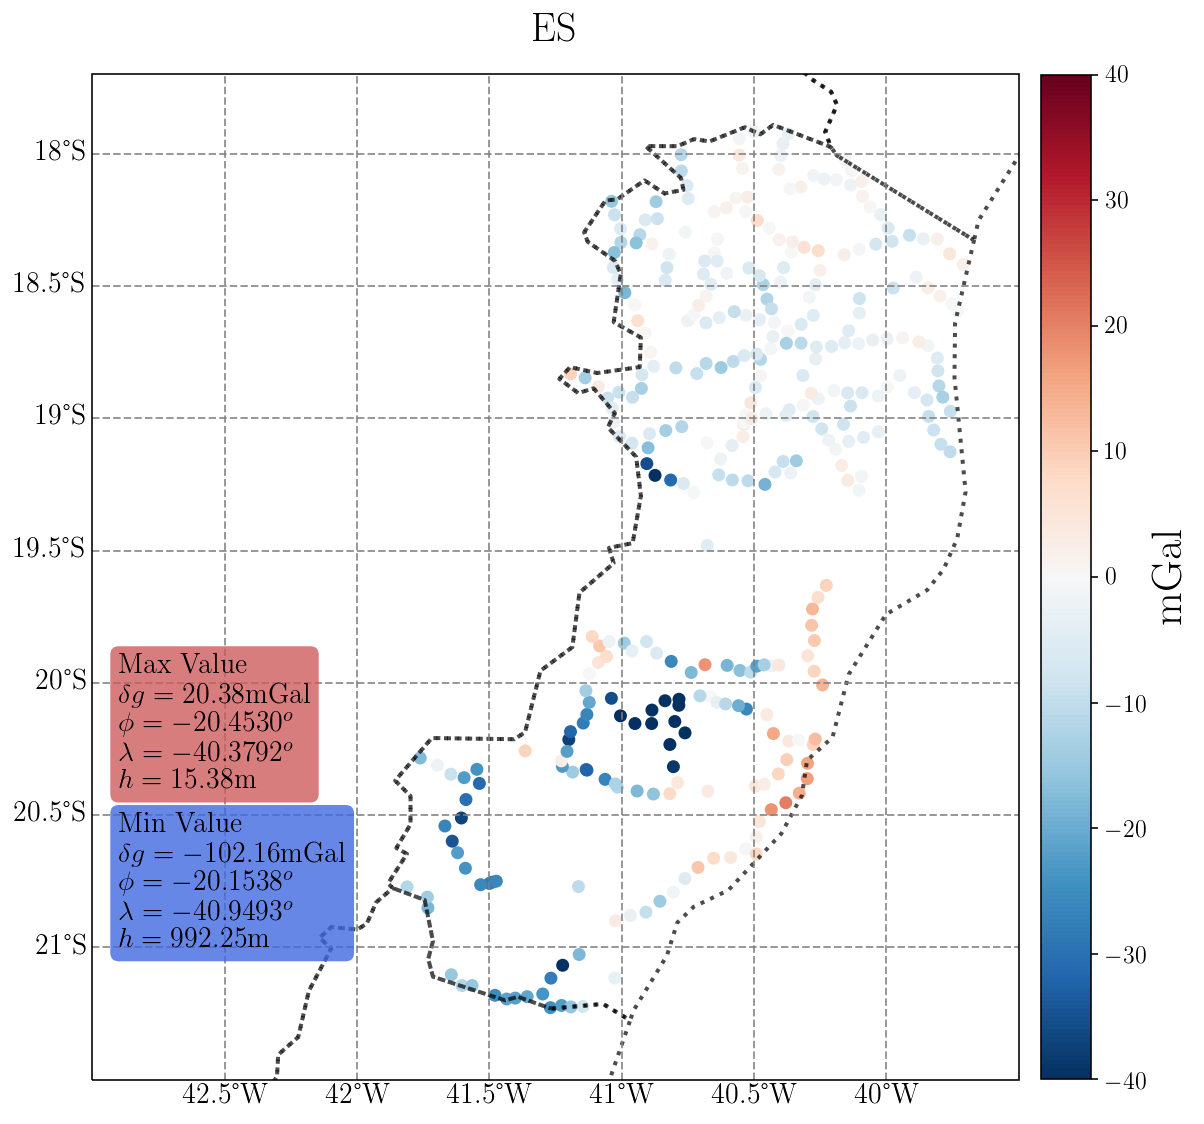

In [34]:
point_map(df.LONG, df.LAT, df.ALT, disturb, uf, fig_size=(10.,12.), region=[-43,-39.5,-21.5,-17.7], \
          sign=(-42.9,-42.9,-20.4,-21), shrink=0.77, lim_val=(True, 40.))

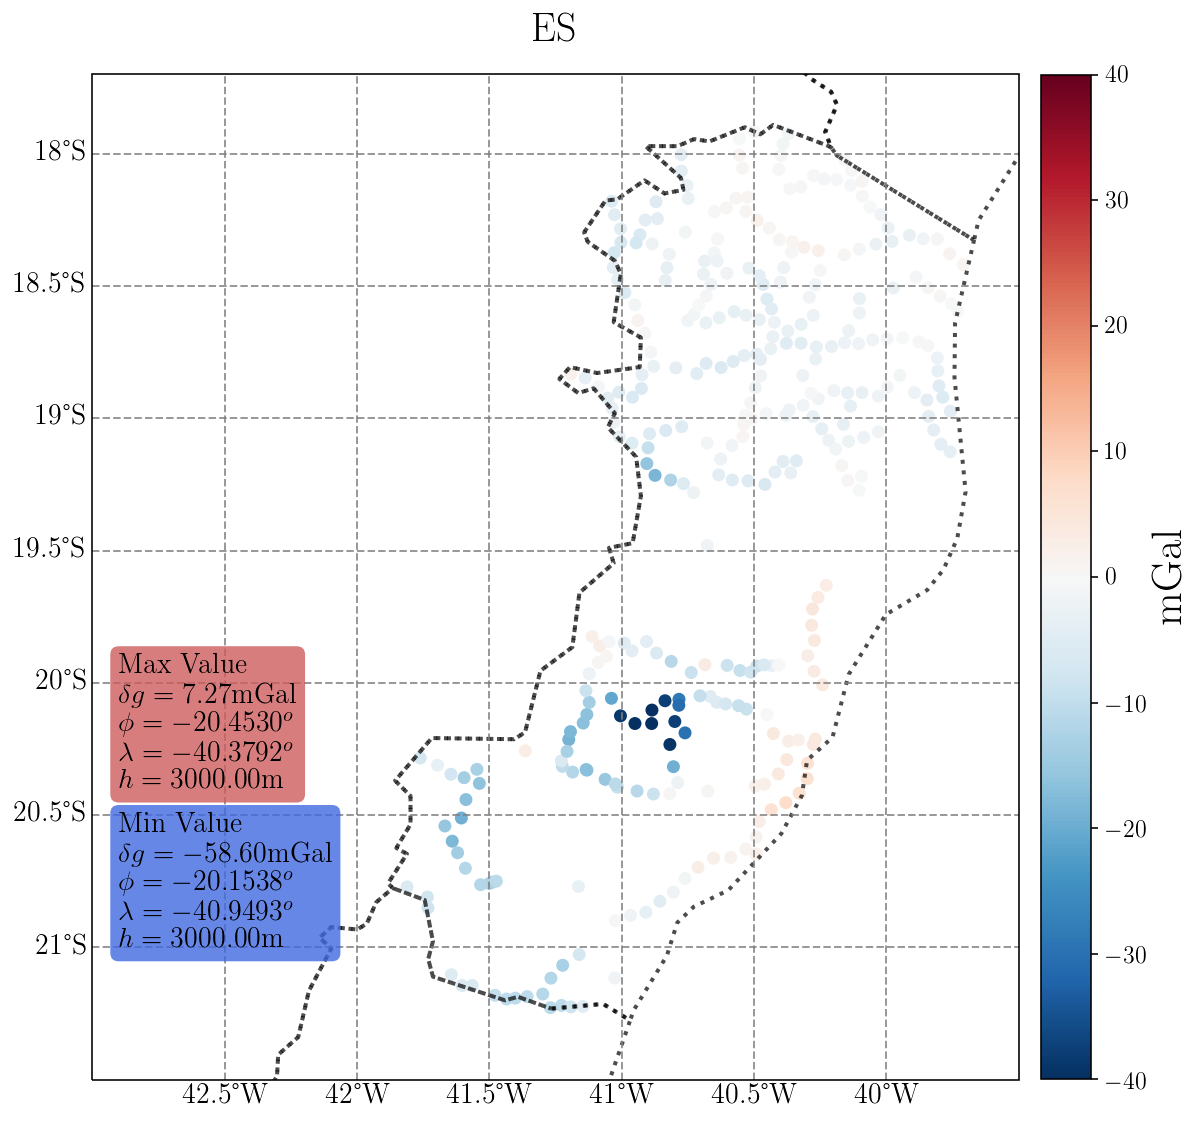

In [35]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(10.,12.), \
          region=[-43,-39.5,-21.5,-17.7], sign=(-42.9,-42.9,-20.4,-21), shrink=0.77, lim_val=(True, 40.))

In [36]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG, df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


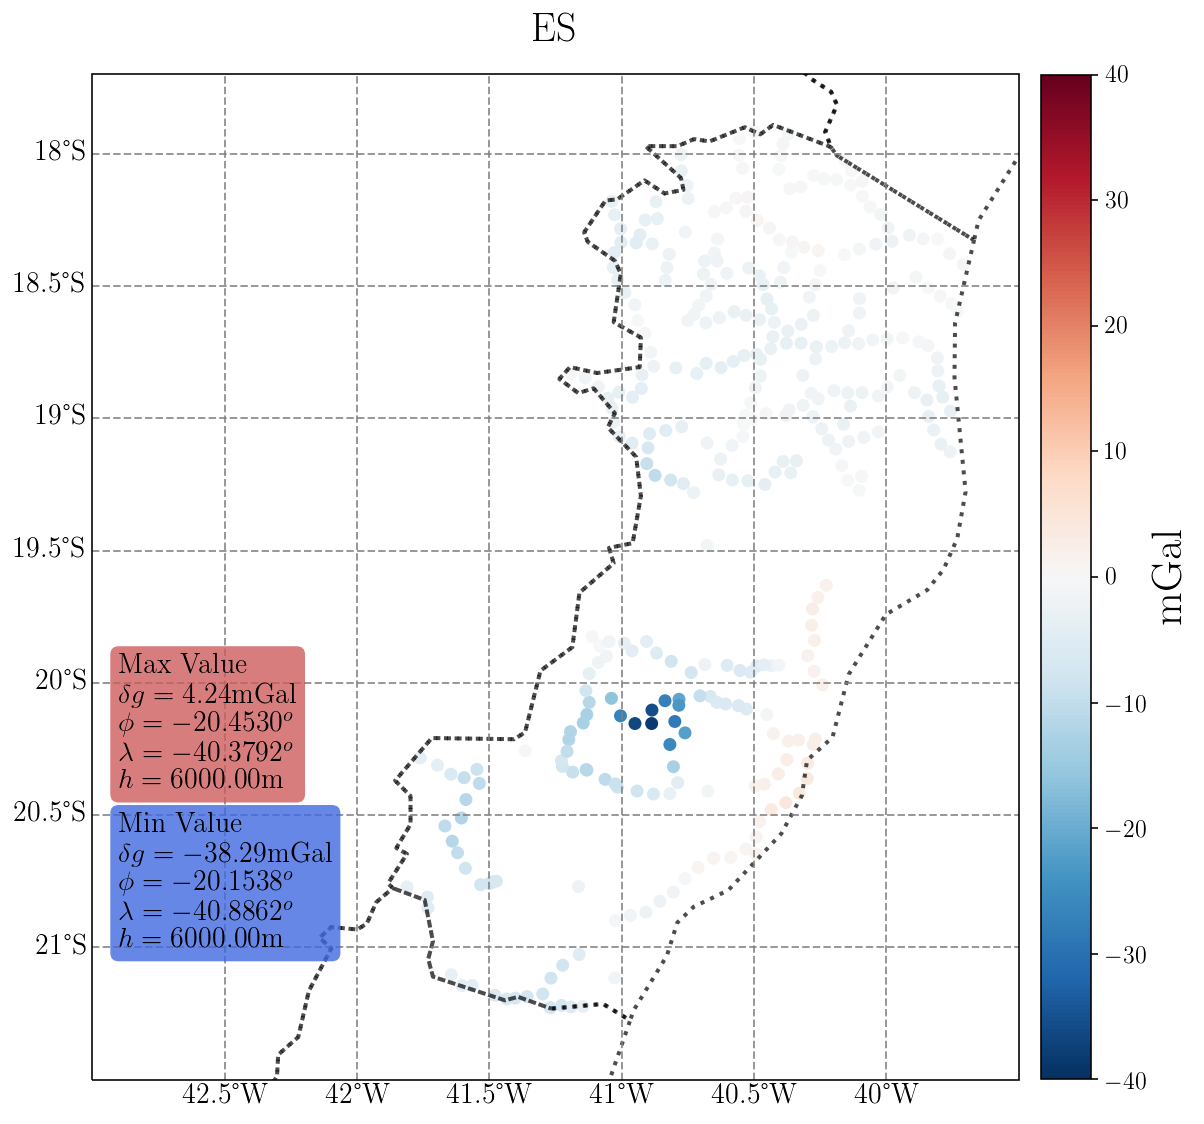

In [37]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(10.,12.), \
          region=[-43,-39.5,-21.5,-17.7], sign=(-42.9,-42.9,-20.4,-21), shrink=0.77, lim_val=(True, 40.))

In [38]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


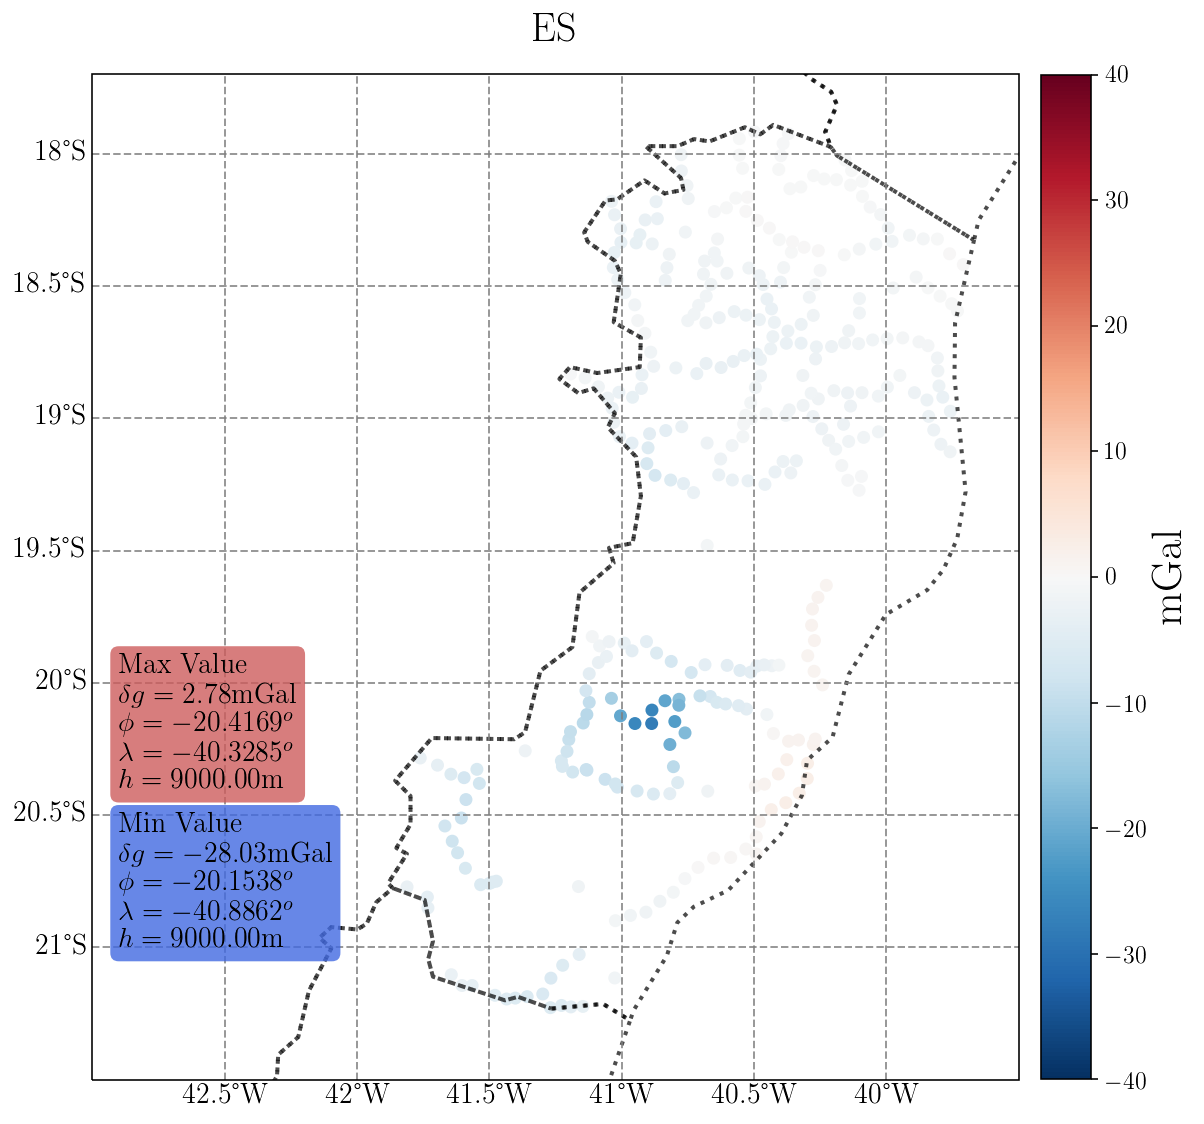

In [39]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(10.,12.), \
          region=[-43,-39.5,-21.5,-17.7], sign=(-42.9,-42.9,-20.4,-21), shrink=0.77, lim_val=(True, 40.))